# 1. Imports and Setup

In [554]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 2. Load Data

In [556]:
data = pd.read_csv('sensor_data.csv', parse_dates=['timestamp'])  

In [557]:
data.head()

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


# 3. Exploratory Data Analysis (EDA)

In [559]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     16857 non-null  datetime64[ns]
 1   equipment_energy_consumption  16013 non-null  object        
 2   lighting_energy               16048 non-null  object        
 3   zone1_temperature             15990 non-null  object        
 4   zone1_humidity                16056 non-null  object        
 5   zone2_temperature             16004 non-null  object        
 6   zone2_humidity                15990 non-null  float64       
 7   zone3_temperature             16055 non-null  float64       
 8   zone3_humidity                15979 non-null  float64       
 9   zone4_temperature             16041 non-null  float64       
 10  zone4_humidity                16076 non-null  float64       
 11  zone5_temperature           

In [560]:
print(data.describe())

                           timestamp  zone2_humidity  zone3_temperature  \
count                          16857    15990.000000       16055.000000   
mean   2016-03-10 02:16:38.647446272       39.494553          21.665733   
min              2016-01-11 17:00:00      -77.265503           6.543921   
25%              2016-02-09 21:20:00       37.757500          20.533333   
50%              2016-03-10 00:10:00       40.293333          21.767500   
75%              2016-04-08 03:40:00       43.000000          22.760000   
max              2016-12-01 15:50:00       77.265503          36.823982   
std                              NaN       10.129513           2.594309   

       zone3_humidity  zone4_temperature  zone4_humidity  zone5_temperature  \
count    15979.000000       16041.000000    16076.000000       16019.000000   
mean        38.201314          20.239922       37.945608          19.052613   
min        -71.406273           4.613485      -81.446225           5.921094   
25%     

## Distribution of target variable

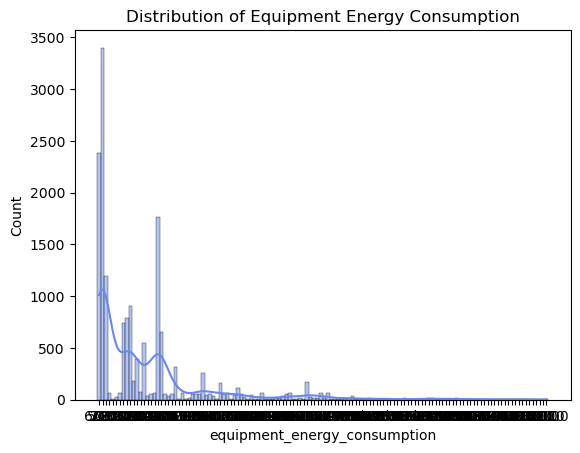

In [562]:
sns.histplot(data['equipment_energy_consumption'], bins=50, kde=True)
plt.title('Distribution of Equipment Energy Consumption')
plt.show()

## Correlation heatmap

In [564]:
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=[np.number])

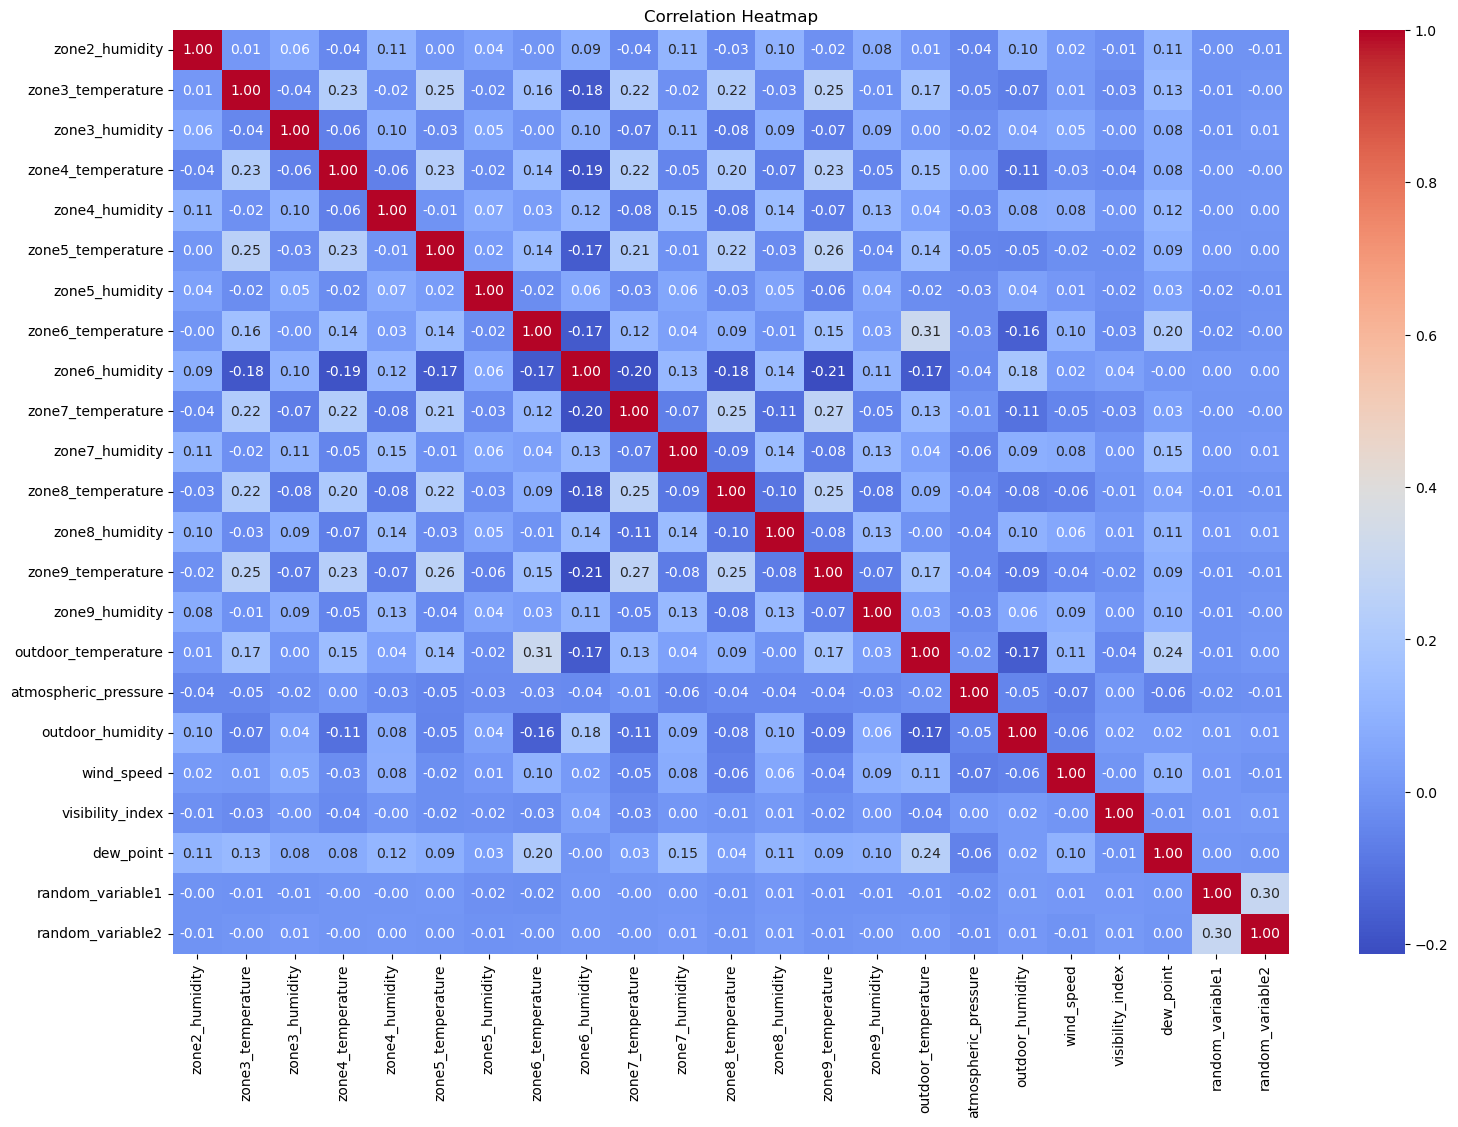

In [565]:
plt.figure(figsize=(18, 12))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 4. Feature Engineering

### Extract time features

In [568]:
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month

### Average temperature/humidity across zones

In [570]:
# Average temperature/humidity across zones
zone_temp_cols = [col for col in data.columns if 'temperature' in col and 'zone' in col]
zone_humidity_cols = [col for col in data.columns if 'humidity' in col and 'zone' in col]

# Convert all columns to numeric, forcing errors to NaN
data[zone_temp_cols] = data[zone_temp_cols].apply(pd.to_numeric, errors='coerce')
data[zone_humidity_cols] = data[zone_humidity_cols].apply(pd.to_numeric, errors='coerce')

# Now calculate the average values
data['avg_zone_temperature'] = data[zone_temp_cols].mean(axis=1)
data['avg_zone_humidity'] = data[zone_humidity_cols].mean(axis=1)


### Delta features

In [572]:
data['temp_delta'] = data[zone_temp_cols].max(axis=1) - data[zone_temp_cols].min(axis=1)
data['humidity_delta'] = data[zone_humidity_cols].max(axis=1) - data[zone_humidity_cols].min(axis=1)

# 5. Data Preprocessing

### Handle missing values (if any)

In [575]:
print(data.isnull().values.any())

True


In [576]:
data.replace(['check', '???', 'error', 'unknown'], np.nan, inplace=True)

In [577]:
data.dropna(inplace=True)

### Define features and target

In [579]:
target = 'equipment_energy_consumption'
features = data.drop(columns=['timestamp', target])
X = features
y = data[target]

### Scale features (for some models like linear regression)

##### Detect non-numeric columns

In [582]:
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['lighting_energy'], dtype='object')


In [583]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Train-test split

In [585]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 6. Model Training & Evaluation

### Linear Regression

In [588]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [589]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\nModel: {model_name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R^2:", r2_score(y_true, y_pred))

In [590]:
evaluate_model(y_test, y_pred_lr, "Linear Regression")


Model: Linear Regression
RMSE: 179.59007387437572
MAE: 74.20791576546672
R^2: 0.018697842919665142


### Ridge Regression

In [592]:
from sklearn.linear_model import Ridge

# Initialize and train Ridge Regression
ridge = Ridge(alpha=1.0)  # You can tune alpha
ridge.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge.predict(X_test)

In [593]:
evaluate_model(y_test, y_pred_ridge, "Ridge Regression")


Model: Ridge Regression
RMSE: 179.58891635200342
MAE: 74.20380871108672
R^2: 0.0187104925668945


### Hyperparameter Tuning

In [595]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Initialize the Ridge Regression model
ridge_model = Ridge()

# Define the hyperparameter grid for RandomizedSearchCV
param_grid = {
    'alpha': np.logspace(-6, 6, 13),  # Regularization strength (log scale)
}

# Use RandomizedSearchCV 
random_search = RandomizedSearchCV(ridge_model, param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters found by RandomizedSearchCV
print("Best Hyperparameters from RandomizedSearchCV:", random_search.best_params_)
print("Best score from RandomizedSearchCV:", random_search.best_score_)


Best Hyperparameters from RandomizedSearchCV: {'alpha': 1000.0}
Best score from RandomizedSearchCV: -33559.73380280513


In [596]:
# Evaluate on the test set with the best model found by GridSearchCV
best_ridge_model = random_search.best_estimator_
test_score = best_ridge_model.score(X_test, y_test)
print("Test score for the best Ridge Regression model:", test_score)

Test score for the best Ridge Regression model: 0.018624069594634696


### Gradient Boosting

In [598]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

# Predict
y_pred_gbr = gbr.predict(X_test)


In [599]:
evaluate_model(y_test, y_pred_gbr, "Gradient Boosting")


Model: Gradient Boosting
RMSE: 181.87791146044447
MAE: 77.55090406301073
R^2: -0.006463459892452006


### Hyperparameter Tuning

In [601]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor()

# Define the hyperparameter grid for GridSearchCV or RandomizedSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],  # Only used for stochastic gradient boosting
    'loss': ['ls', 'lad', 'huber']  # Specify the loss function
}

# Use RandomizedSearchCV for a faster, randomized search
random_search = RandomizedSearchCV(gb_model, param_grid, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

# Print the best hyperparameters found by RandomizedSearchCV
print("Best Hyperparameters from RandomizedSearchCV:", random_search.best_params_)
print("Best score from RandomizedSearchCV:", random_search.best_score_)


Best Hyperparameters from RandomizedSearchCV: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 4, 'loss': 'huber', 'learning_rate': 0.05}
Best score from RandomizedSearchCV: -32018.241776629537


In [602]:
# Evaluate on the test set with the best model found by RandomizedSearchCV
best_gb_model = random_search.best_estimator_
test_score = best_gb_model.score(X_test, y_test)
print("Test score for the best Gradient Boosting model:", test_score)

Test score for the best Gradient Boosting model: 0.07713019408055777


# 7. Feature Importance (Gradient Boosting)

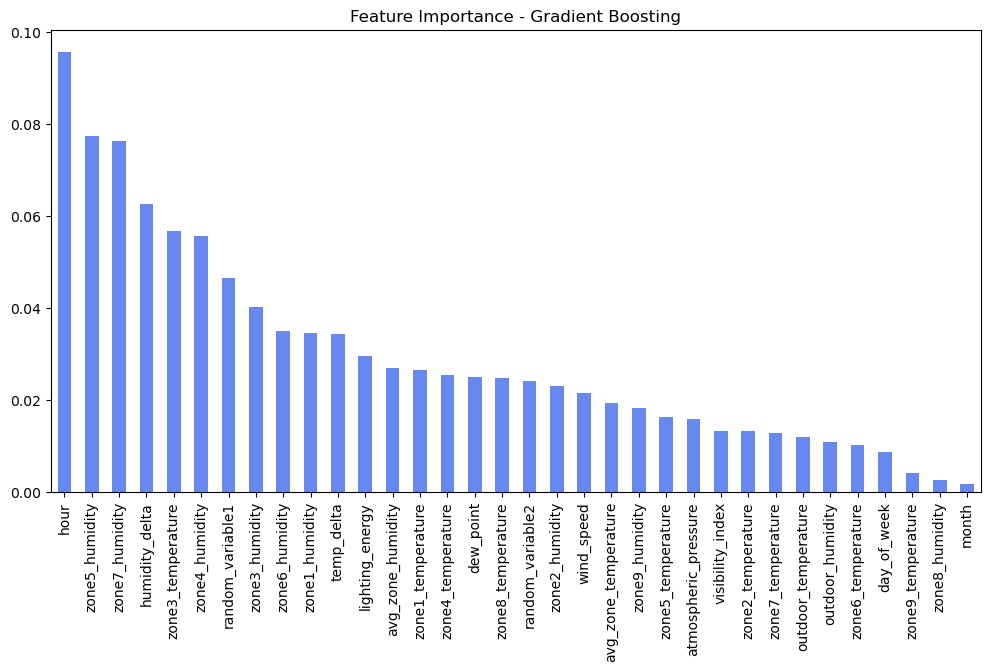

In [604]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

plt.figure(figsize=(12, 6))
importances_gb = pd.Series(gb.feature_importances_, index=features.columns).sort_values(ascending=False)
importances_gb.plot(kind='bar')
plt.title('Feature Importance - Gradient Boosting')
plt.show()

# 8. Check usefulness of random variables

In [606]:
print("Correlation with target:")
print(data[['random_variable1', 'random_variable2', target]].corr())

Correlation with target:
                              random_variable1  random_variable2  \
random_variable1                      1.000000          0.271706   
random_variable2                      0.271706          1.000000   
equipment_energy_consumption         -0.033042         -0.023400   

                              equipment_energy_consumption  
random_variable1                                 -0.033042  
random_variable2                                 -0.023400  
equipment_energy_consumption                      1.000000  
